## Automatic Number-Plate Recognition
Using PyTesseract OCR Reader

#### Let's experiment with PyTesseract

In [1]:
ls ../../images

4star.jpg*                           facialRecognition.gif
Hillary.jpg*                         facialRecognition.psd
IMG_7539.jpg*                        findingLanes.gif
IMG_8295.JPG*                        findingLanes.psd
Object_Detector_AR.gif               flower.gif
Object_Detector_AR.psd               flower.psd
Origin_of_Species.jpg*               gradient.jpg*
Sunflowers.jpg*                      hand.jpg*
Trump.jpg*                           house.jpg*
WaldoBeach.jpg*                      input.jpg*
abraham.jpg*                         input33.JPG*
abraham_mask.png*                    kim.jpg*
beatle.jpg*                          lourve_noise.jpg*
blobs.jpg*                           marsface.jpg*
bottlecaps.jpg*                      mask.jpg*
box_in_scene.png*                    numbers.jpg*
bunchofshapes.jpg*                   obama.jpg*
candy.jpg*                           obamafacerecog.jpg*
cannyEdgeDetection.gif               opencv.png*
cannyEdgeDetection.psd         

In [10]:
import cv2
import pytesseract as tess
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [11]:
ls

03_Automatic_Number_Plate_Recognition.ipynb*
OCRtestimg.png
car3.jpg*


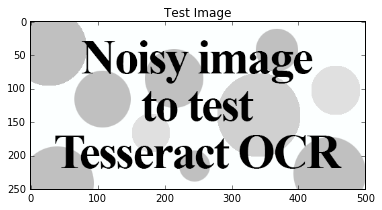

In [12]:
img = cv2.imread("OCRtestimg.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Test Image'); plt.show()

In [14]:
test_image = Image.fromarray(img)
text = tess.image_to_string(test_image, lang='eng')
print("PyTesseract Detected the following text: ", text)

('PyTesseract Detected the following text: ', u'Noisyimage\nto test\nTesseract OCR')


### Let's build our ANPR System

DETECTING PLATE . . .


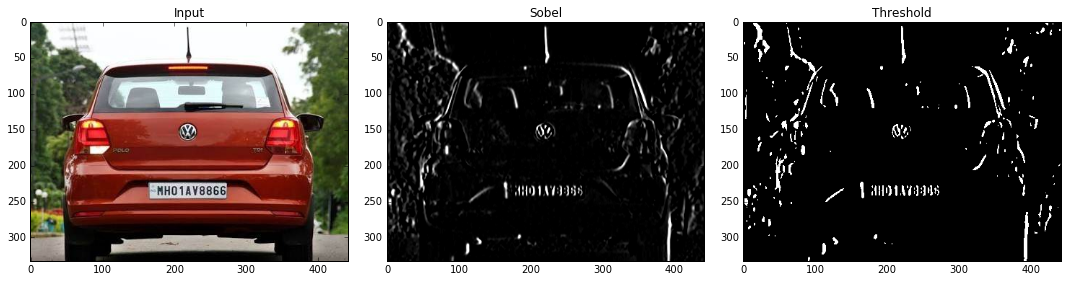

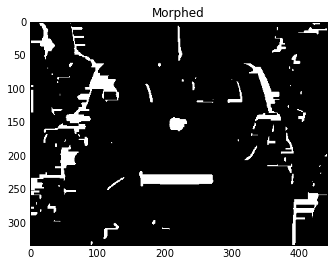

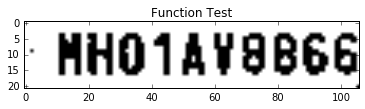

('Detected Text : ', u'MHO1A\xa5SB66')


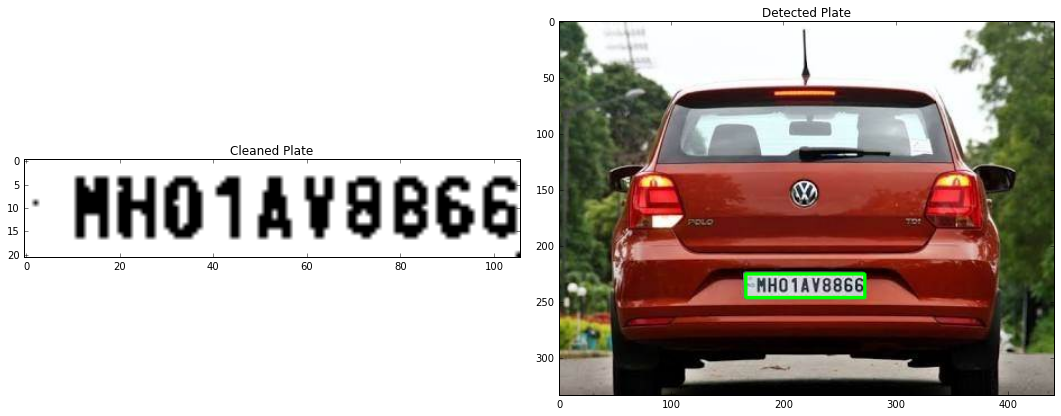

In [20]:
import numpy as np
import cv2
from copy import deepcopy
from PIL import Image
import pytesseract as tess

def preprocess(img):
    """This function takes an image, applies blurring, uses sobel
    to get horizontal lines. It then returns the binarized image"""

    imgBlurred = cv2.GaussianBlur(img, (5,5), 0)
    gray = cv2.cvtColor(imgBlurred, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray,cv2.CV_8U,1,0,ksize=3)

    ret2,threshold_img = cv2.threshold(sobelx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    
    row, col = 1, 3
    fig, axs = plt.subplots(row, col, figsize=(15, 10))
    fig.tight_layout()

    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Input')
    cv2.imwrite('Input.jpg', img)

    axs[1].imshow(cv2.cvtColor(sobelx, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Sobel')
    cv2.imwrite('Sobel.jpg', sobelx)
    
    axs[2].imshow(cv2.cvtColor(threshold_img, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Threshold')
    cv2.imwrite('Threshold.jpg', threshold_img)

    plt.show()
    
    
    return threshold_img

def cleanPlate(plate):
    """This function gets the countours that most likely resemeber the shape
    of a license plate"""    
    gray = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    thresh = cv2.dilate(gray, kernel, iterations = 1)

    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if contours:
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)

        max_cnt = contours[max_index]
        max_cntArea = areas[max_index]
        x,y,w,h = cv2.boundingRect(max_cnt)

        if not ratioCheck(max_cntArea,w,h):
            return plate,None

        cleaned_final = thresh[y:y+h, x:x+w]
        plt.imshow(cv2.cvtColor(cleaned_final, cv2.COLOR_BGR2RGB))
        plt.title('Function Test'); plt.show()
        
        return cleaned_final,[x,y,w,h]

    else:
        return plate, None

def extract_contours(threshold_img):
    """This function returns the extracted contours"""
    element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
    morph_img_threshold = threshold_img.copy()
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)
    #cv2.imshow("Morphed", morph_img_threshold)
    #cv2.waitKey(0)
    
    plt.imshow(cv2.cvtColor(morph_img_threshold, cv2.COLOR_BGR2RGB))
    plt.title('Morphed'); plt.show()

    contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    return contours


def ratioCheck(area, width, height):
    """This function inspects the ratio of the contour to ensure it meets the requirements 
    suitable to a real license plate"""
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio

    aspect = 4.7272
    min = 15 * aspect * 15  # minimum area
    max = 125 *aspect * 125  # maximum area

    rmin = 3
    rmax = 6

    if (area < min or area > max) or (ratio < rmin or ratio > rmax):
        return False
    return True

def isMaxWhite(plate):
    """Checks the average color of the potential plate and if there is more
    white than black colors it returns true"""
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
        return False

def validateRotationAndRatio(rect):
    """Checks the angle of the rectangle potential license plate"""
    (x, y), (width, height), rect_angle = rect

    if(width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle

    if angle>15:
        return False

    if height == 0 or width == 0:
        return False

    area = height*width
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

def cleanAndRead(img,contours):
    """Takes the extracted contours and once it passes the rotation
    and ratio checks it passes the potential license plate to PyTesseract for OCR reading"""
    for i,cnt in enumerate(contours):
        min_rect = cv2.minAreaRect(cnt)

        if validateRotationAndRatio(min_rect):

            x,y,w,h = cv2.boundingRect(cnt)
            plate_img = img[y:y+h,x:x+w]

            if(isMaxWhite(plate_img)):
                clean_plate, rect = cleanPlate(plate_img)
                
                if rect:
                    row, col = 1, 2
                    fig, axs = plt.subplots(row, col, figsize=(15, 10))
                    fig.tight_layout()
                    
                    x1,y1,w1,h1 = rect
                    x,y,w,h = x+x1,y+y1,w1,h1
                    
                    axs[0].imshow(cv2.cvtColor(clean_plate, cv2.COLOR_BGR2RGB))
                    axs[0].set_title('Cleaned Plate')
                    cv2.imwrite('cleaned_plate.jpg', clean_plate)
                    
                    plate_im = Image.fromarray(clean_plate)
                    text = tess.image_to_string(plate_im, lang='eng')
                    print("Detected Text : ", text)

                    img = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
                    axs[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    axs[1].set_title('Detected Plate')
                    cv2.imwrite('detected_plate.jpg', img)
                    
                    plt.show()

if __name__ == '__main__':
    print("DETECTING PLATE . . .")

    # Path to the license plate you wish to read
    img = cv2.imread("car3.jpg")
    threshold_img = preprocess(img)
    contours= extract_contours(threshold_img)
    cleanAndRead(img,contours)
    cv2.destroyAllWindows()